In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import time
import math
import gc
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
import nltk 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,5)
import numpy as np 
import pandas as pd 
from xgboost import plot_importance
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 

In [ ]:
df_train=pd.read_csv("drive/MyDrive/Datasets-Collab/Workstation/Train.csv")
df_test=pd.read_csv("drive/MyDrive/Datasets-Collab/Workstation/Test.csv")
submission=pd.read_csv("drive/MyDrive/Datasets-Collab/Workstation/sample submission.csv")

In [ ]:
df_train[df_train

In [ ]:
df_train[df_train['Travel Date']=='27-10-2021'].describe()

,Flight Stops,Meals,Per Person Price
count,58.000000,58.000000,58.00000
mean,0.758621,3.844828,23800.12069
std,0.801541,0.987674,22925.71065
min,0.000000,2.000000,4566.50000
25%,0.000000,3.000000,13095.87500
50%,1.000000,3.000000,18626.00000
75%,1.000000,5.000000,26069.00000
max,2.000000,5.000000,170763.00000


In [ ]:
df_train[(df_train['Destination']=='Coorg') & (df_train['Package Name']=='Offbeat Coorg - Bonfire & Nature Walk')]

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
3635,69fe31907446f8f8e098122ebb3dcf68,Offbeat Coorg - Bonfire & Nature Walk,Premium,Coorg,3N Coorg,Coorg,27-10-2021,Taj Madikeri Resort & Spa:4.7,New Delhi,Vistara,0,5,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,170763.0
5895,96c2709d9578729c57eec9bde217e8d1,Offbeat Coorg - Bonfire & Nature Walk,Premium,Coorg,3N Coorg,Coorg,27-03-2022,Taj Madikeri Resort & Spa:4.7,Mumbai,Go Air,0,5,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,25991.0
12094,0ae9ca6f0872943ede9bb40ffa7f1c3b,Offbeat Coorg - Bonfire & Nature Walk,Premium,Coorg,3N Coorg,Coorg,07-07-2021,Taj Madikeri Resort & Spa:4.7,New Delhi,Go Air,0,5,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,28072.0
12223,bcb3622b3986ad19094d7e1800b7784b,Offbeat Coorg - Bonfire & Nature Walk,Standard,Coorg,3N Coorg,Coorg,16-09-2021,Misty Woods Resorts:3.3,New Delhi,IndiGo,2,3,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,12131.0
12808,ca7f163b144b1d34f96cbc91b7d34210,Offbeat Coorg - Bonfire & Nature Walk,Budget,Coorg,3N Coorg,Coorg,27-07-2021,KSTDC Mayura Valley View:4.2,New Delhi,IndiGo,2,2,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,10617.5
14147,69d8ed5be1d5aa93b59381c49fecc9ab,Offbeat Coorg - Bonfire & Nature Walk,Budget,Coorg,3N Coorg,Coorg,11-11-2021,KSTDC Mayura Valley View:4.2,New Delhi,Go Air,2,2,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,11062.5
14952,4fde8cacf168c80186aa589be7978f34,Offbeat Coorg - Bonfire & Nature Walk,Standard,Coorg,3N Coorg,Coorg,31-05-2021,Misty Woods Resorts:3.3,New Delhi,IndiGo,2,3,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,16093.5
15260,5dc73425b336edac0dcb47f436b4f7e1,Offbeat Coorg - Bonfire & Nature Walk,Premium,Coorg,3N Coorg,Coorg,17-03-2021,Taj Madikeri Resort & Spa:4.7,New Delhi,Go Air,0,5,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,27253.0
18272,b0f266382dd70e4fa0640310351679d3,Offbeat Coorg - Bonfire & Nature Walk,Premium,Coorg,3N Coorg,Coorg,30-10-2021,Taj Madikeri Resort & Spa:4.7,New Delhi,Go Air,0,5,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,33298.5


In [ ]:
df_train[df_train['Uniq Id']=='69fe31907446f8f8e098122ebb3dcf68']

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
3635,69fe31907446f8f8e098122ebb3dcf68,Offbeat Coorg - Bonfire & Nature Walk,Premium,Coorg,3N Coorg,Coorg,27-10-2021,Taj Madikeri Resort & Spa:4.7,New Delhi,Vistara,0,5,Dubare Elephant Camp | Tibetan Temple | Talac...,This cancellation policy is applicable for boo...,170763.0


In [ ]:
df_train.drop(df_train.loc[df_train['Uniq Id']=='69fe31907446f8f8e098122ebb3dcf68'].index,axis=0,inplace=True)

In [ ]:
df_train.groupby(['Package Type'])['Per Person Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Package Type,,,,,,,,
Budget,466.0,14151.447425,8236.467588,1757.0,8901.250,13114.25,17927.00,64008.5
Deluxe,6006.0,18409.508825,10228.326587,1198.0,12119.000,16426.75,22774.25,171062.5
Luxury,3278.0,23679.556437,11958.923869,2963.0,15471.625,22222.50,29170.75,107850.0
Premium,5580.0,23939.099194,13127.477759,2967.0,15230.375,21765.00,29182.00,166758.0
Standard,5669.0,16354.089081,9363.498521,791.0,10563.500,14729.50,19972.00,153795.0


In [ ]:
# df_train=df_train.replace({'Not Available':None},regex=True)

In [ ]:
merged=pd.concat([df_train,df_test])
merged=merged.reset_index()
merged.drop(['index'],axis=1,inplace=True)

In [ ]:
merged

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,75171484ea20440a5c08fe040a9a01a7,Trip to Kerala,Standard,Munnar|Thekkady|Allepey,2N Munnar . 1N Thekkady . 1N Allepey,Munnar|Thekkady|Allepey,04-06-2021,Iceberg Hill Hotel-MMT Holidays Special:4|Elep...,New Delhi,Vistara,2,3,Valara Waterfalls | Tea Plantation at Devikul...,Cancellation any time after making the 1st pay...,NaN
29995,16f57cebfb653f2c532314322598ca3a,Magical Kashmir Holiday,Deluxe,Srinagar|Pahalgam|Srinagar|Gulmarg,1N Srinagar . 1N Pahalgam . 1N Srinagar . 1N G...,Srinagar|Pahalgam|Srinagar|Gulmarg,07-03-2021,California Group of Houseboats:Three|The China...,Mumbai,IndiGo,1,3,Dal Lake | Pahalgam | Avantipura Ruins | Beta...,Cancellation any time after making the 1st pay...,NaN
29996,477f8b3f07e1a6c027152e2cd5d67e4a,Holiday in Dharamshala and Dalhousie from Delhi,Luxury,Dharamshala|Dalhousie,3N Dharamshala . 2N Dalhousie,Dharamshala|Dalhousie,21-08-2021,Little Mastiff Dharamshala - Unit Of Pong View...,Mumbai,Vistara,0,4,Dalai Lama temple | Bhagsu falls | Church of ...,Cancellation any time after making the 1st pay...,NaN
29997,c9ce916ec5e1b93134a2f84090284bf9,"Colorful Rajasthan- Jaipur, Jodhpur, Jaisalmer...",Deluxe,Jaipur|Jodhpur|Jaisalmer|Udaipur,2N Jaipur . 1N Jodhpur . 2N Jaisalmer . 2N Uda...,Jaipur|Jodhpur|Jaisalmer|Udaipur,19-03-2021,Souvenir Peppermint:3.9|Lariya Resort:4.3|Gorb...,New Delhi,IndiGo|IndiGo,1,3,City Palace | Hawa Mahal | Jantar Mantar | Ra...,Cancellation any time after making the 1st pay...,NaN


In [ ]:
merged=merged.replace({'Alibagh':'Alibag'},regex=True)
merged=merged.replace({'Chikmangalur':'Chikmagalur'},regex=True)
merged=merged.replace({'Tiruchirapally': 'Tiruchirappalli'},regex=True)

In [ ]:
merged.head(20)

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price
0,e788ab76d9d8cf1e6ed2f139645ca5d1,Best of Shimla and Manali Holiday from Delhi,Standard,New Delhi|Shimla|Manali|Chandigarh,1N New Delhi . 2N Shimla . 2N Manali . 1N Chan...,New Delhi|Shimla|Manali|Chandigarh,30-07-2021,Not Available,Mumbai,Not Available,2,3,Not Available,Not Available,11509.0
1,178f892630ce3e335a5a41d5d83937fd,Kashmir Valley vacation,Premium,Srinagar|Pahalgam|Srinagar,1N Srinagar . 2N Pahalgam . 1N Srinagar,Srinagar|Pahalgam|Srinagar,08-12-2021,The Orchard Retreat & Spa:4.6|WelcomHotel Pine...,New Delhi,IndiGo|IndiGo,0,5,Dal Lake | Avantipura Ruins | Mughal Gardens ...,Cancellation any time after making the 1st pay...,22485.5
2,f060f2954840503cc2fdaf495357b7df,Might of Mewar- Udaipur and Chittorgarh,Luxury,Udaipur|Chittorgarh,2N Udaipur . 1N Chittorgarh,Udaipur|Chittorgarh,26-04-2021,The Ananta:4.4|juSTa Lake Nahargarh Palace:4,New Delhi,IndiGo,0,4,Lake Pichola | Jag Mandir Palace | Saheliyon ...,Cancellation any time after making the 1st pay...,12421.5
3,32a19a6c171e67448f2346da46c619dc,Colorful Kerala ( Romantic Getaway ),Premium,Munnar|Kumarakom|Allepey|Kovalam and Poovar,2N Munnar . 1N Kumarakom . 1N Allepey . 2N Kov...,Munnar|Kumarakom|Allepey|Kovalam and Poovar,27-08-2021,Elixir Hills Suites Resort & Spa-MMT Holidays ...,New Delhi,IndiGo,0,5,Mattupetty Dam | Echo Point | Tata Tea Museum...,Cancellation any time after making the 1st pay...,35967.0
4,107b068aa0ca03bc6248966f594d105f,A Week In Bangkok & Pattaya,Premium,Pattaya|Bangkok,4N Pattaya . 3N Bangkok,Pattaya|Bangkok,12-12-2021,Dusit Thani Pattaya - MMT Special:4.5|Amari Wa...,New Delhi,Spicejet|Go Air,0,5,"Coral Island Tour with Indian Lunch, Join Spe...",Cancellation any time after making the 1st pay...,25584.0
5,3bb074528941b3a6823371f77b07fb0f,Cochin Trip with Visit to Guruvayoor Temple,Deluxe,Cochin,2N Cochin,Cochin,30-09-2021,Not Available,Mumbai,IndiGo,1,3,Dutch Palace | Jewish Synagogue | St. Francis...,Not Available,8512.0
6,644c71b1a9ccfe6eacc6303be12c1352,Jaipur Holiday,Standard,Jaipur,3N Jaipur,Jaipur,24-01-2021,Ratnawali A Vegetarian Heritage Hotel:4.1,New Delhi,IndiGo,2,3,Hawa Mahal | City Palace | Jantar Mantar | Am...,Cancellation any time after making the 1st pay...,6848.0
7,07943295cfdce5cb20861e8369948b1d,Kasol & Manali holiday from Delhi,Deluxe,Kasol|Manali,2N Kasol . 3N Manali,Kasol|Manali,10-12-2021,The Himalayan Village:Four|The Holiday Resorts...,Mumbai,Not Available,1,3,Pandoh Dam | Hadimba Temple | Tibetan Monaste...,Cancellation any time after making the 1st pay...,14454.5
8,126e12c63233bf11ef2e001a062f2a53,Charismatic Kashmir with Gulmarg,Deluxe,Srinagar|Gulmarg|Pahalgam|Srinagar,1N Srinagar . 1N Gulmarg . 2N Pahalgam . 2N Sr...,Srinagar|Gulmarg|Pahalgam|Srinagar,03-10-2021,California Group of Houseboats:3.6|The Rosewoo...,New Delhi,IndiGo,1,3,Dal Lake | Gondola Point | Avantipura Ruins |...,Cancellation any time after making the 1st pay...,21556.5
9,72aeb7bac6d5600fe443fca06e3db631,Luxury Getaway to Udaipur - Stay at the Chunda...,Premium,Udaipur,2N Udaipur,Udaipur,15-08-2021,Chunda Palace:4.6,Mumbai,IndiGo,0,5,Lake Pichola | Jag Mandir Palace | Sajjangarh...,This cancellation policy is applicable for boo...,13042.0


In [ ]:
temp=pd.DataFrame(columns=['Destination','Start_city'])
temp['Start_city']=merged['Start City'].copy()
temp['Destination']=merged['Destination'].str.split('|',expand=True)[0].copy()
temp['Distance']=0

In [ ]:
Delhi_cord=(28.6138954, 77.2090057)
Mumbai_cord=(19.0759899, 72.8773928)

In [ ]:
from geopy.geocoders import Nominatim
import geopy.distance

geolocator = Nominatim(user_agent = "geoapiExercises")

coordinates_cities={}
for values in temp['Destination'].unique():
  location = geolocator.geocode(values,timeout=10000)
  cords=(location.latitude, location.longitude)
  coordinates_cities[values]=cords

delhi_distance={}
mumbai_distance={}

for key,values in coordinates_cities.items():
  d_distance=geopy.distance.vincenty(Delhi_cord, values).km
  m_distance=geopy.distance.vincenty(Mumbai_cord, values).km
  delhi_distance[key]=d_distance
  mumbai_distance[key]=m_distance


In [ ]:
temp

(30000, 3)

In [ ]:
for index,row in temp.iterrows():
  if(row['Start_city']=='New Delhi'):
    destination_city=row['Destination']
    total_distance=delhi_distance[destination_city]
    temp.at[index,'Distance']=total_distance

  else:
    destination_city=row['Destination']
    total_distance=mumbai_distance[destination_city]
    temp.at[index,'Distance']=total_distance


In [ ]:


# for index,row in temp.iterrows():
#   location = geolocator.geocode(row['Destination'],timeout=10000)
#   cords=(location.latitude, location.longitude)
#   if(row['Start_city']=='New Delhi'):
#     temp.at[index,'Distance']=geopy.distance.vincenty(Delhi_cord, cords).km
#   else:
#     temp.at[index,'Distance']=geopy.distance.vincenty(Mumbai_cord, cords).km
#   print("yes")

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


KeyboardInterrupt: ignored

In [ ]:
from geopy.geocoders import Nominatim
import geopy.distance

geolocator = Nominatim(user_agent = "geoapiExercises")

location = geolocator.geocode("Alibag")
print((location.latitude, location.longitude))

(18.6571882, 72.95201127018711)


In [ ]:
#calculating the distance from start point to first city

In [ ]:
mumbai=(1.357107, 103.8194992)
delhi=(28.6517178, 77.2219388)
print(geopy.distance.vincenty(mumbai, delhi).km)

4136.0776937444025


In [ ]:
# df_train['Travel Date'].unique().sort_values()

In [ ]:
# df_train=df_train[df_train['Per Person Price']<0000]

In [ ]:
#sns.lineplot(df_train['Travel Date'],df_train['Per Person Price'])

In [ ]:
df_train['Places Covered'].nunique()

565

In [ ]:
df_train['Travel Date']=pd.to_datetime(df_train['Travel Date'],format='%d-%m-%Y')
df_train['Day']=df_train['Travel Date'].dt.day
df_train['Month']=df_train['Travel Date'].dt.month
df_train['Year']=df_train['Travel Date'].dt.year

In [ ]:
df_train=df_train.sort_values('Travel Date')

In [ ]:
#sns.barplot(df_train['Travel Date'],df_train['Per Person Price'])

In [ ]:
#@title
print('train set shape',df_train.shape)
print('test set shape',df_test.shape)


train set shape (21000, 15)
test set shape (9000, 14)


## Unique ID check in train and and any overlap with the test set
1. Unique ID seems unique we can drop

In [ ]:
#@title
list1=df_train['Uniq Id'].unique().shape
list2=df_test['Uniq Id'].unique().shape
set(list1).intersection(set(list2))

set()

# Combining Test and Train set for better understanding

In [ ]:
merged=pd.concat([df_train,df_test])
merged=merged.reset_index()
merged.drop(['index'],axis=1,inplace=True)

In [ ]:
temp=pd.DataFrame()
temp['Sightseeing Places Covered']=merged['Sightseeing Places Covered'].copy()

temp.loc[temp['Sightseeing Places Covered']=='Not Available','Sightseeing Places Covered']=None

temp['Sightseeing Places Covered'].fillna(0,inplace=True)
temp['Sightseeing Places Covered']=temp['Sightseeing Places Covered'].str.replace('\W+',' ')
temp['Sightseeing Places Covered']=temp['Sightseeing Places Covered'].str.lower()

temp['Sightseeing Places Covered'].fillna('-999',inplace=True)


In [ ]:
temp=df_train[['Package Name', 'Package Type', 'Destination', 'Itinerary',
       'Places Covered', 'Travel Date', 'Hotel Details', 'Start City',
       'Airline', 'Flight Stops', 'Meals', 'Sightseeing Places Covered',
       'Cancellation Rules']]

In [ ]:
temp[temp.duplicated(keep = False)].index

Int64Index([], dtype='int64')

In [ ]:
index=[1267,  1941,  2039,  2452,  3271,  3854,  3858,  4282,  5306,
             5589,  6091,  6832,  6915,  7293,  7706,  8130,  8334,  8763,
             9571,  9663, 10666, 11991, 13514, 13868, 13985, 14480, 14745,
            16827, 17078, 17551, 17873, 18392, 18538, 18760, 19085, 19144,
            19188, 20609, 20860, 20954]
df_train.drop(index,inplace=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

feature_count = 30
tfidf = TfidfVectorizer(max_features=feature_count)
Package_features = pd.DataFrame(tfidf.fit_transform(temp['Sightseeing Places Covered']).toarray())

Package_features.columns=[*range(0,30)]
Package_features.columns = [str(col) + 'Sight_Name_' for col in Package_features.columns]

#merged=pd.concat([Package_features,merged],axis=1)

In [ ]:
Package_features

,0Sight_Name_,1Sight_Name_,2Sight_Name_,3Sight_Name_,4Sight_Name_,5Sight_Name_,6Sight_Name_,7Sight_Name_,8Sight_Name_,9Sight_Name_,10Sight_Name_,11Sight_Name_,12Sight_Name_,13Sight_Name_,14Sight_Name_,15Sight_Name_,16Sight_Name_,17Sight_Name_,18Sight_Name_,19Sight_Name_,20Sight_Name_,21Sight_Name_,22Sight_Name_,23Sight_Name_,24Sight_Name_,25Sight_Name_,26Sight_Name_,27Sight_Name_,28Sight_Name_,29Sight_Name_
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.604421,0.553554,0.416342,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.393589,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.421620,0.000000,0.000000,0.297663,0.0,0.000000,0.0,0.348182,0.000000,0.000000,0.782562,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,0.0,0.000000,0.000000,0.000000,0.341029,0.000000,0.000000,0.360007,0.000000,0.000000,0.0,0.000000,0.0,0.290071,0.343375,0.000000,0.000000,0.276265,0.607691,0.0,0.0,0.000000,0.000000,0.326244,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.847595,0.000000,0.000000,0.000000,0.0,0.387665,0.0,0.000000,0.362352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.316122,0.357429,0.000000,0.278410,0.000000,0.000000,0.293903,0.000000,0.202449,0.0,0.000000,0.0,0.236809,0.280325,0.000000,0.000000,0.225538,0.248054,0.0,0.0,0.000000,0.000000,0.532680,0.191385,0.0,0.000000,0.0,0.000000,0.000000
29996,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.325161,0.489123,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.299653,0.0,0.0,0.000000,0.000000,0.000000,0.231196,0.0,0.000000,0.0,0.715392,0.000000
29997,0.0,0.000000,0.000000,0.591029,0.000000,0.207621,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.162133,0.000000,0.198804,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.687815,0.000000,0.262067,0.0,0.000000,0.0,0.000000,0.000000
29998,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.682322,0.000000,0.000000,0.000000,0.0,0.365328,0.0,0.000000,0.000000,0.000000,0.633224,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [ ]:
#@title
merged.loc[merged['Package Name'].str.contains('self'),'Flight Stops']=0
merged.loc[merged['Package Name'].str.contains('self'),'Meals']=0

In [ ]:
#@title
merged['Package Name'].nunique()

2236

In [ ]:
#@title
#merged['travel local'].sum(axis=0)

In [ ]:
#@title
merged['travel local']=merged['Package Name'].map(lambda x: 1 if 'from' in x else 0)

In [ ]:
#@title
merged.shape

(30000, 15)

In [ ]:
#@title
#sns.histplot(merged[merged['Package Name'].str.contains('short')]['Per Person Price'])

In [ ]:
merged[merged['Package Name'].str.contains('Special')].shape

(3609, 15)

In [ ]:
# temp=merged['Package Name'].str.split('-',expand=True)[1].dropna()
# temp.iloc[200:250,]

## Adding flights included column

In [ ]:
# for values in merged[merged['Airline']=='Not Available']['Package Name']:
#   #print(values)

SyntaxError: ignored

In [ ]:
# merged[merged['Package Name'].str.contains('Getaway')]

In [ ]:
# temp=merged[merged['Package Name'].str.contains('from')&(merged['Airline']=='Not Available')&(merged['Package Name'].str.contains('without'))]


In [ ]:
# merged=pd.concat([df_train,df_test]).rese

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# merged['Package Name']=merged['Package Name'].str.replace('\W+',' ')
# merged['Package Name']=merged['Package Name'].str.lower()
# feature_count = 25
# tfidf = TfidfVectorizer(max_features=feature_count)
# Package_features = pd.DataFrame(tfidf.fit_transform(merged['Package Name']).toarray())

# Package_features.columns=[*range(0,25)]
# Package_features.columns = [str(col) + 'Package_Name_' for col in Package_features.columns]

# merged=pd.concat([Package_features,merged],axis=1)

In [ ]:
merged['Package Name']=merged['Package Name'].str.lower()
merged.loc[merged['Package Name'].str.contains('with flights'),'flights_included']=1
merged['flights_included'].fillna(0,inplace=True)
# merged.loc[merged['Package Name'].str.lower()]
# .str.contains('With Flights')]

## Checking if Destination and Place covered columns are the same

In [ ]:
#merged.loc[merged['Destination']!=merged['Places Covered']]

In [ ]:
#merged[(merged['Day']==31 )& (merged['Month']==12)].shape

## Cancellation rules

In [ ]:
# #@title
# merged['Cancellation Rules'].value_counts()

In [ ]:
#@title
cancel_encode=LabelEncoder()
temp=merged[['Cancellation Rules']].copy()
merged['Cancellation Rules']=cancel_encode.fit_transform(merged['Cancellation Rules'])

In [ ]:
#@title
merged.loc[merged['Cancellation Rules']==2,'Cancellation Rules']=1
merged.loc[merged['Cancellation Rules']==9,'Cancellation Rules']=6
merged.loc[merged['Cancellation Rules']==7,'Cancellation Rules']=6

In [ ]:
# #@title
# merged['Cancellation Rules'].value_counts()

In [ ]:
#@title
merged[merged['Airline']=='Not Available'].shape

(7010, 15)

In [ ]:
# #@title
# temp=merged[(merged['Package Name'].str.contains('from')) & (merged['Airline']=='Not Available')]


<!-- a
## one:
1. Non refundable

## two:
1. If the customer chooses to make the payment in total and cancels the booking within 24 hours of making the payment, the customer shall be entitled to get the full refund under this offer.

2. This cancellation policy is applicable for bookings made for Weekend Getaways through the MakeMyTrip platform  

3. Full refund under the offer is not applicable on Air Asia, Scoot Airlines, Nok-Scoot & Tiger Australia.

4. Same as first




## three=


1.   Price of the booking is calculated for per passenger on a twin-sharing basis
2.   Porter fee at hotels, airports and seaports is not included in the package and has to be borne by the customer.Cost of expenses of personal nature such as, laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included.
3. Package price does not include Gala dinner charges applicable on Christmas and New Year's Eve







## four= 'GENERAL' Nine

1.   Please expect to receive your vouchers 72 hours before your departure date (subject to full payment of your package cost)
2.   Please note that these packages are customizable, which means that you will be able to make changes to the itinerary/activity 
if you so desire. 
3.  laundry, telephone calls, room service, alcoholic beverages, mini bar etc., are not included
4. Please note that if your package includes a flight which is a low cost carrier (Air Asia, Scoot Airlines, Air Arabia, Jetstar, Fly Dubai, Thai AirAsia, Air India Express, Tiger Airways) then baggage will not be included in the package.
5. Please note that 'Day at Leisure' essentially implies that no sightseeing activities have been included for that day Kindly be on time for your activities, tours and transfers.
 -->


In [ ]:
#@title
import difflib
output_list = [li for li in difflib.ndiff(merged['Cancellation Rules'].unique()[4], merged['Cancellation Rules'].unique()[9]) if li[0] != ' ']

In [ ]:
#@title
output_list

NameError: ignored

In [ ]:
#@title
# merged[merged['Package Name'].str.contains('MMT')]

In [ ]:
#@title
# merged['Cancellation Rules'].unique()[2]

In [ ]:
# #@title
# merged['Cancellation Rules'].unique()[5]

## Analyzing the Hotel Details column

In [ ]:
merged=pd.concat([df_train,df_test])
merged=merged.reset_index()
merged.drop(['index'],axis=1,inplace=True)

In [ ]:
merged.loc[merged['Hotel Details']=='Not Available','Hotel Details']=None
merged['Hotel Details'].fillna(0,inplace=True)

In [ ]:
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Two','2')
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Three','3')
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Four','4')
merged['Hotel Details'] = merged['Hotel Details'].str.replace('Five','5')

merged['Hotel Details'] = merged['Hotel Details'].str.replace('The Lodhi:A member of The Leading Hotels Of The World',
                                                              'The Lodhi A member of The Leading Hotels Of The World')

temp=pd.DataFrame()
temp['Hotel Details']=merged['Hotel Details']
merged['Hotel Details']=merged['Hotel Details'].str.split('|')
merged['Hotel Details'].fillna(0,inplace=True)

In [ ]:
merged=pd.concat([df_train,df_test])
merged=merged.reset_index()
merged.drop(['index'],axis=1,inplace=True)


In [ ]:
temp=pd.DataFrame()
temp['Hotel Details']=merged['Hotel Details']

In [ ]:
temp.loc[temp['Hotel Details']=='Not Available','Hotel Details']=None
temp['Hotel Details'].fillna(0,inplace=True)
temp['Hotel Details']=temp['Hotel Details'].str.replace('1','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('2','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('3','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('4','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('5','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('6','')

temp['Hotel Details']=temp['Hotel Details'].str.replace('7','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('8','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('9','')
temp['Hotel Details']=temp['Hotel Details'].str.replace('0','')
#temp['Hotel Details']=temp['Hotel Details'].str.replace('\W+',' ')
temp['Hotel Details']=temp['Hotel Details'].str.lower()
temp["Hotel Details"]=temp["Hotel Details"].str.replace('the','')
temp["Hotel Details"]=temp["Hotel Details"].str.replace('hotel','')

In [ ]:
temp['Hotel Details'].fillna('-999',inplace=True)

In [ ]:
teemp=pd.DataFrame()
teemp['Hotel Details']=temp['Hotel Details'].copy()
teemp['MMT-Special']=0
teemp.loc[teemp['Hotel Details'].str.contains('mmt'),'MMT-Special']=1

In [ ]:
teemp.iloc[4]

Hotel Details    dusit thani pattaya - mmt special:.|amari wate...
MMT-Special                                                      1
Name: 4, dtype: object

In [ ]:
teemp['Hotel Details'].map(lambda x: x.count('mmt'))

0        0
1        0
2        0
3        1
4        2
        ..
29995    2
29996    0
29997    0
29998    0
29999    0
Name: Hotel Details, Length: 30000, dtype: int64

In [ ]:
teemp['MMT-Special'].value_counts()

0    22328
1     7672
Name: MMT-Special, dtype: int64

In [ ]:
temp[temp['Hotel Details'].str.contains('mmt') & (~temp['Hotel Details'].str.contains('special'))]

,Hotel Details


In [ ]:
for values in temp[temp['Hotel Details'].str.contains('mmt holidays special')]['Hotel Details']:
  print(values)

Streaming output truncated to the last 5000 lines.
park regis jaipur - mmt holidays special:|saira fort by sarovar - mmt holidays special:|park plaza - mmt holidays special:
mahaweli reach-mmt holidays special:.|citrus waskaduwa-mmt holidays special:.|galadari -mmt holidays special:.
summit namnang courtyard & spa, gangtok-mmt holidays special:three
sea shell resort-mmt holidays special:.|sandyy wavess beach resort:|sea shell resort-mmt holidays special:
poppys :.|hyatt place rameswaram:.| temple citi:.|over  hill-mmt holidays special:|oxygen resorts alleppey-mmt holidays special:|crown valley-mmt holidays special:|tea village-mmt holidays special:
diviyum manor-mmt holidays special:.|sunrise beach resort:|diviyum manor-mmt holidays special:
camelot beach :.|oak ray city -mmt holidays special:|heaven seven-mmt holidays special:|coco royal beach-mmt holidays special:.|best western elyon - mmt holidays special:
summit denzong  & spa:.|delight lachen heritage:.|summit alpine resort, lachu

In [ ]:
s#Package Name tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

feature_count = 25

tfidf = TfidfVectorizer(max_features=feature_count)

Package_features = pd.DataFrame(tfidf.fit_transform(temp['Hotel Details']).toarray())

Package_features.columns=[*range(0,25)]
Package_features.columns = [str(col) + 'HotelName_' for col in Package_features.columns]

merged=pd.concat([Package_features,merged],axis=1)

In [ ]:
merged.columns

Index(['0HotelName_', '1HotelName_', '2HotelName_', '3HotelName_',
       '4HotelName_', '5HotelName_', '6HotelName_', '7HotelName_',
       '8HotelName_', '9HotelName_', '10HotelName_', '11HotelName_',
       '12HotelName_', '13HotelName_', '14HotelName_', '15HotelName_',
       '16HotelName_', '17HotelName_', '18HotelName_', '19HotelName_',
       '20HotelName_', '21HotelName_', '22HotelName_', '23HotelName_',
       '24HotelName_', 'Uniq Id', 'Package Name', 'Package Type',
       'Destination', 'Itinerary', 'Places Covered', 'Travel Date',
       'Hotel Details', 'Start City', 'Airline', 'Flight Stops', 'Meals',
       'Sightseeing Places Covered', 'Cancellation Rules', 'Per Person Price'],
      dtype='object')

In [ ]:
empty_rating_hotels=[]
for i in merged['Hotel Details']:
  if (i!=0):
    for values in i:
      x=values.split(':')[1]
      if(x==''):
        empty_rating_hotels.append(values)

In [ ]:
len(empty_rating_hotels)

10580

In [ ]:
average_hotel_ratings

NameError: ignored

In [ ]:
#@title
# temp=pd.DataFrame(columns=['Hotel Details'])
# temp['Hotel Details']=merged['Hotel Details']
# # temp.columns=[*range(0,11)]
# # for i in temp.columns:
# #   temp[i]=temp[i].str.split(':',expand=True)[1]


In [ ]:
#@title
# temp=pd.DataFrame()
# temp=merged['Hotel Details'].apply(pd.Series)
# temp.columns=[*range(0,11)]

# for i in temp.columns:
#   temp[i]=temp[i].str.split(':',expand=True)[1]

# temp = temp.replace('Two',2)
# temp = temp.replace('Three',3)
# temp = temp.replace('Four',4)
# temp = temp.replace('Five',5)
# merged['Hotel Details'].fillna(0,inplace=True)

In [ ]:
#@title
# sorted(set(empty_rating_hotels))

In [ ]:
#@title
# i=20
# for values in merged[temp.eq('').any(1)]['Hotel Details']:
#   print(values)
#   print('\n')
#   i=i-1
#   if(i==0):
#     break

In [ ]:
#@title
# for hotels in merged['Hotel Details']:
#   if(hotels!=0):
#     for values in hotels:
#       if('A member of The Leading Hotels Of The World' in values):
#         print(values)

In [ ]:
#@title
# # check what to impute
# average_rating={}
# no_rating_hotels=[]
# for empty_hotels in sorted(empty_rating_hotels):
#   rating=[]
#   for hotels in merged['Hotel Details']:
#     if(hotels!=0):
#       for values in hotels:
#         if(empty_hotels in values):
#           x=values.split(':')[1]
#           if(x!=''):
#             rating.append(float(x))

#   if(len(rating)!=0):
#     average_rating[empty_hotels]=round(sum(rating)/len(rating),1)
#   else:
#     no_rating_hotels.append(empty_hotels)

# no_rating_hotels=sorted(set(no_rating_hotels))


In [ ]:
#@title
average_rating={'175 Metropolitan Executive Motel on Riccarton:': 4.5,
 'A One Star Hotel Pattaya - MMT Special:': 3.4,
 'ATDC Houseboat:': 3.8,
 'AVANI Atrium Bangkok:': 4.0,
 'Adya Hotel Langkawi - MMT Special:': 4.0,
 'Amari Watergate Hotel Bangkok - MMT Special:': 4.4,
 'Ambassador Hotel Bangkok  MMT Special:': 4.0,
 'Anand Portico:': 4.2,
 'Ananda Lakshmi Ayurveda Retreat:': 4.5,
 'Aonang Paradise Resort Krabi - MMT Special:': 3.4,
 'Apple Valley Resort:': 4.3,
 'Arcadia Heritage Resort:': 3.3,
 'Arcadia Regency:': 3.6,
 'Arrowtown House Boutique Accommodation:': 4.4,
 'Atapattu Walauwa:': 4.0,
 'BEST WESTERN Elyon - MMT HOLIDAYS SPECIAL:': 4.0,
 'Beach & Lake Ayurvedic Resort:': 4.1,
 'Best Western Kuta Beach-MMT Special:': 3.1,
 'Bhanwar Singh Palace:': 3.7,
 'Blue Bells Valley Resort:': 4.4,
 'Brys Caves:': 4.3,
 'COCOLAND HERITAGE BEACH RESORT:': 3.5,
 'California Group of Houseboats:': 3.5,
 'Camelot Beach Hotel:': 4.0,
 'Camelot Hotel, Alleppey- MMT Holidays Special:': 3.9,
 'Casino Hotel - Cgh Earth-MMT Holidays Special:': 4.5,
 'Casino Hotel - Cgh Earth:': 4.4,
 'Centara Ceysands Resort (MMT HOLIDAYS SPECIAL):': 3.5,
 'Cinnamon Bey Beruwala Hotel(MMT HOLIDAYS SPECIAL):': 4.0,
 'Cinnamon Thekkady:': 4.4,
 'Clarkes Hotel, A grand heritage hotel since 1898:': 4.9,
 'Clarks Resort Abhyaran, Ranthambore:': 4.6,
 'Club Mahindra Poovar:': 4.1,
 'Coco Royal Beach-MMT HOLIDAYS SPECIAL:': 4.0,
 'Cocobay Resort:': 3.7,
 "Copthorne King's Hotel - MMT Special:": 3.5,
 'Coral Cove-MMT HOLIDAYS SPECIAL:': 4.8,
 'Corbett Adventure Resort:': 3.8,
 'Country Resort By AHRPL, Katra:': 4.5,
 'Crown Valley-MMT Holidays Special:': 4.1,
 'Deevana Patong Resort & Spa - MMT Special:': 4.1,
 'Delight Lachen Heritage:': 3.2,
 'Desert Springs Resort:': 4.5,
 'Detour Moonlight:': 5.0,
 'Diviyum Manor-MMT Holidays Special:': 3.1,
 'DoubleTree by Hilton Resort  & Spa Marjan Island:': 4.8,
 'Dubai Marriott Hotel Al Jaddaf-MMT Special:': 5.0,
 'Dusit Thani Krabi Beach Resort - MMT SPECIAL:': 4.2,
 'Economy Houseboat by ATDC  - MMT Special:': 4.5,
 'Elephant Route Resort-MMT Holidays Special:': 3.9,
 'Elephant Route Resort:': 3.9,
 'Elixir Hills Suites Resort & Spa-MMT Holidays Special:': 4.5,
 'Estuary Sarovar Portico:': 4.4,
 'Evoke Avaas Lifestyle:': 3.7,
 'Fair View Hotel Colombo:': 4.0,
 'Fateh Garh Resort by Fateh Collection:': 4.8,
 'Federal Hotel - MMT Special:': 3.7,
 'Fernhill Resort:': 3.5,
 "Fortune Resort Bay Island-Member ITC's Hotel Group:": 4.2,
 'Fortune Resort Sullivan Court-Member ITC Hotel Group:': 4.2,
 'Furama Bukt Bintang - MMT Special:': 4.0,
 'Furama Hotel Bukit Bintang:': 4.0,
 'Galadari Hotel-MMT HOLIDAYS SPECIAL:': 3.5,
 'Gateway Varkala - IHCL SeleQtions:': 3.9,
 'Gem Park:': 4.1,
 'Genting Dream Ex Sin - MMT Special:': 4.0,
 'Grand Ion Delemen- MMT Special:': 4.0,
 'Grand Nirvana Jacuzzi Super Luxury Houseboat:': 4.4,
 'Grand View Hotel:': 4.5,
 'Greenwoods Resort:': 4.7,
 'HAVELOCK HOLIDAY BEACH RESORT:': 3.3,
 'HAYWIZZ HAVELOCK ISLAND RESORTS:': 3.7,
 'HOTEL GATEWAY SHILLONG:': 3.5,
 'HOTEL HERITAGE MANDAWA:': 3.9,
 'HOTEL NANDA:': 4.9,
 'HOTEL PINK MOUNTAIN-MMT HOLIDAYS SPECIAL:': 3.9,
 'Hard Rock Hotel Penang:': 3.9,
 'Haus Berlin:': 4.2,
 'Havelock Country Homes- MMT Holiday Special:': 3.3,
 'Havelock Country Homes:': 4.1,
 'Heaven Seven-MMT HOLIDAYS SPECIAL:': 3.9,
 'Heritage Kuchaman Haveli:': 3.8,
 'Heritage Madurai:': 4.4,
 'Hilton Garden Inn Dubai Al Muraqabat (Deira) - MMT Special:': 4.0,
 'Hilton Garden Inn New Delhi Saket:': 4.4,
 'Hilton Garden Inn:': 4.6,
 'Hilton Pattaya - MMT Special:': 4.2,
 'Holiday Inn Express Krabi Ao Nang  MMT Special:': 3.3,
 'Holiday Inn Resort Batam:': 3.1,
 'Holiday Villa Beach Resort & Spa Langkawi MMT Special:': 3.5,
 'Hotel 100 Petals- MMT HOLIDAYS SPECIAL:': 4.1,
 'Hotel 100 Petals:': 4.5,
 'Hotel 6 Chandigarh Zirakpur(Medallion):': 4.0,
 'Hotel Baljees Regency:': 3.8,
 'Hotel Boss - MMT Special:': 3.7,
 'Hotel Continental Blue:': 4.0,
 'Hotel Ganga Vilas:': 3.5,
 'Hotel Hilltone:': 4.1,
 'Hotel Hillview, Munnar - MMT Special:': 4.0,
 'Hotel Horizon:': 3.8,
 'Hotel Jem Valley:': 3.8,
 'Hotel Master Paradise:': 3.9,
 'Hotel Maya Kuala Lumpur - MMT Special:': 4.1,
 'Hotel Pegasus Crown:': 2.9,
 'Hotel Port Palace:': 4.0,
 'Hotel Radhika Palace:': 3.9,
 'Hotel Rains Inn:': 3.9,
 'Hotel Ranthambhore National Resort:': 3.8,
 'Hotel Royale Park:': 3.9,
 'Hotel Sandra Palace-MMT Holidays Special:': 4.0,
 'Hotel Shompen:': 3.4,
 'Hotel Silver Oak (A Boutique Garden Hotel):': 4.3,
 'Hotel Sivamurugan:': 4.0,
 'Hotel Span International-MMT Holidays Special:': 4.0,
 'Hotel Temple Citi:': 4.2,
 'Hotel The Royal Plaza:': 3.7,
 'Hotel Treetop:': 4.1,
 'Hotel Udai Vilas Palace:': 3.5,
 'Hotel Vintage:': 3.7,
 'Hotel Welbeck Residency:': 3.2,
 'Hotel Yois Udaipur - MMT Holidays Special:': 4.1,
 'Hummingbird Resort:': 3.3,
 'Hyatt Place Rameswaram:': 4.4,
 'Hyatt Regency Amritsar:': 4.3,
 'Hyatt Regency- MMT Holidays Special:': 4.4,
 'INFINITEA TEA GARDEN RESORT:': 4.5,
 'Ibis Styles Fraser Business Park - MMT Special:': 3.4,
 'Iceberg Hill Hotel-MMT Holidays Special:': 3.9,
 'Indana Palace Jodhpur:': 4.3,
 'Indra Maya Pool Villas:': 4.0,
 'J Hotel:': 3.3,
 'JW Marriott Chandigarh:': 4.7,
 'JW Marriott Mussoorie Walnut Grove:': 4.6,
 'Jain Group Lachung Continental:': 3.4,
 'Jain Group Sanderling Resort & spa:': 4.1,
 'Jet Park Hotel Auckland Airport:': 4.5,
 'Jungle Vilas:': 3.7,
 'KAZIRANGA FLORICAN LODGE:': 3.8,
 'KOFILAND:': 4.4,
 'Keys Select Hotel Aqua Green-MMT Holidays Special:': 4.8,
 'Keys Select Hotel Kochi-MMT Holidays Special:': 3.9,
 'King Thai Hotel and Restaurant Cum Bar:': 4.7,
 'Kshetra Ayurveda & Yoga Retreat, Varkala:': 4.3,
 'Kuta Central Park Hotel - MMT Special:': 4.0,
 'Kyriad Hotel Shimla (A unit of Hotel C K Int.):': 3.6,
 'Lake Palace Backwater Resort:': 4.4,
 'Larisa Resort:': 4.7,
 'Le Fenix - MMT Special:': 3.3,
 'Leisure Inn Grand Chanakya:': 3.9,
 'Leisure inn grand chanakya - MMT Holidays Special:': 4.1,
 'Lemon Tree Hotel  Gangtok:': 4.2,
 'Lemon Tree Premier Jaipur:': 4.3,
 'Little Mastiff Dharamshala - Unit Of Pong View Hotel:': 3.9,
 'Long Beach Resort & Spa - MMT Special:': 4.0,
 'MERCURE SINGAPORE ON STEVENS - MMT SPECIAL:': 4.0,
 'Madurai Residency:': 4.1,
 "Magellan's Group The Grand Lachen:": 3.0,
 'Maharaja Ganga Mahal:': 4.2,
 'Mandarin Oriental, Singapore:': 4.5,
 'Marari Beach - CGH Earth:': 4.5,
 'Mayfair Himalayan Spa Resort:': 4.6,
 'Mayfair Hotel:': 4.6,
 'Mayfair Spa Resort & Casino:': 4.6,
 'Megapode Resort:': 4.0,
 'Metro Hotel Bukit Bintang - MMT Special:': 3.5,
 'Moksha Himalaya Spa Resort:': 4.4,
 'Mount Himalayan Hotel & Spa-MMT Holidays Special:': 4.0,
 'Mount Lavinia Hotel (MMT HOLIDAYS SPECIAL):': 4.0,
 'Mount Lavinia Hotel-MMT HOLIDAYS SPECIAL:': 4.0,
 'Mountain Club Resort-MMT Holidays Special:': 4.3,
 'Movenpick Hotel Bur Dubai-MMT Special:': 4.7,
 'Movenpick Hotel Colombo:': 4.5,
 'Movenpick Hotel Myth Patong - MMT Special:': 4.3,
 'Movenpick Hotel Sukhumvit 15 - MMT Special:': 4.5,
 'Movenpick Resort and Spa Karon Beach Phuket - MMT Special:': 4.2,
 'Niraamaya Retreats Backwaters and beyond, Kumarakom:': 4.9,
 'Niraamaya Retreats Surya Samudra:': 4.6,
 'Nisala Arana Boutique Hotel:': 4.4,
 'Novotel Bangkok Silom Road - MMT Special:': 4.3,
 'Nubra Ecolodge:': 4.2,
 'OYO 14240 MOHAN RESIDENCY:': 3.4,
 'OYO 22517 Mananya Cottage:': 4.0,
 'OYO 28229 Samfelma Lodge:': 4.3,
 'OYO 45438 RUPSAJJA PARIBAR:': 5.0,
 'OYO 47847 Himalayan Brook:': 4.5,
 'OYO 48394 Hotel Ratna Saver:': 4.5,
 'OYO Home 42381 Budget Stay Near Medical College:': 5.0,
 'Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:': 4.0,
 'Oakwood Hotel Journeyhub Phuket - MMT Special:': 3.1,
 'Ocean Bay Ayurvedic Beach Resort:': 3.2,
 'Omega Residency:': 3.9,
 'One Farrer Hotel:': 4.6,
 'Orchard Hotel Singapore:': 4.0,
 'Over The Hill:': 4.4,
 'Oxygen Resorts Alleppey-MMT Holidays Special:': 4.0,
 'PARKROYAL Parramatta:': 4.0,
 'PARKROYAL on Kitchener Road:': 4.0,
 'Pacific Regency Hotel Suite - MMT Special:': 3.7,
 'Palace Hotel (Bikaner House), A Heritage Hotel:': 4.3,
 'Palette - Pine Tree Spa Resort:': 3.6,
 'Palmtree Leaf-MMT Holidays Special:': 3.9,
 'Pappukutty Beach Resort:': 3.4,
 'Parakkat Nature Resorts-MMT Holidays Special:': 4.6,
 'Parakkat Nature Resorts:': 4.5,
 'Park Hotel Farrer Park - MMT Special:': 4.1,
 'Park Plaza - MMT Holidays Special:': 4.3,
 'Park Regis Aveda Kumarakom:': 4.5,
 'Park Regis Jaipur - MMT Holidays Special:': 4.3,
 'Pavilions Hotel:': 4.0,
 'Pearl Grand Hotel-MMT HOLIDAYS SPECIAL:': 4.0,
 'Pearl Park Beach Resort-MMT Holidays Special:': 3.3,
 'Pearl Park Beach Resort:': 3.7,
 'Poovar Island Resort:': 4.2,
 'Poppys Hotel:': 4.1,
 'Punnamada Resort:': 4.0,
 'Pushkar Resorts:': 4.3,
 'Quality Airport Hotel:': 4.1,
 'Quality Hotel Marlow:': 3.0,
 "Queen's Hotel, Kandy(MMT HOLIDAYS SPECIAL):": 4.1,
 'R.J Resorts Ltd.:': 3.9,
 'RAMADA JAIPUR:': 4.2,
 'ROOPKATHA  HOTEL KALIMPONG:': 3.9,
 'Radisson Blu Haridwar:': 4.2,
 'Radisson Blu Hotel Dubai Deira Creek - MMT Special:': 4.5,
 'Radisson Blu Hotel, Abu Dhabi Yas Island:': 4.4,
 'Radisson Hotel Varanasi:': 3.9,
 'Radisson Srinagar:': 4.0,
 'Raffles Jakarta:': 5.0,
 'Raj Palace Resort, Ranthambhore:': 3.3,
 'Ramada Alleppey:': 4.0,
 'Ramada Plaza Chandigarh:': 4.3,
 'Ramada by Wyndham Darjeeling Gandhi Road:': 4.3,
 'Ramada by Wyndham Phuket Deevana Patong - MMT Special:': 4.3,
 'Red Fox Hotel - MMT Holiday Special:': 3.8,
 'Red Fox Hotel Chandigarh:': 3.7,
 'Red Fox Hotel Delhi Airport:': 3.6,
 'Regenta Central Antarim:': 4.3,
 'Renai Green Fields:': 3.8,
 'Resorts World Genting,Resort Hotel:': 3.5,
 'Royal Group of Deluxe Houseboats:': 3.7,
 'Royal Sarovar Portico:': 4.0,
 'S R CASTLE:': 3.7,
 'SDM Golden Tower:': 4.0,
 'SUMITEL SUITES & SPA:': 4.1,
 'Sagara Beach Resort - MMT Holidays Special:': 3.9,
 'Sagara Beach Resort:': 3.8,
 'Saira fort by Sarovar - MMT Holidays Special:': 4.2,
 'San Nael LaResort:': 4.1,
 'Savoy Ooty - IHCL SeleQtions:': 4.5,
 'Sea Shell Neil Island:': 4.6,
 'Sea Shell Resort-MMT Holidays Special:': 4.9,
 'Sea Shell Samssara:': 4.3,
 'Shree Ram International:': 3.8,
 'Shri Ram Empire:': 4.1,
 'Siam Bayshore Resort Pattaya:': 4.5,
 'Silver Sand Beach Resort:': 4.0,
 'SkyCity Grand Hotel:': 4.5,
 'Snow Valley Resorts:': 4.3,
 'Solang Valley Resort:': 4.0,
 'Soma Kerala Palace:': 3.9,
 'Sugar Beach Mauritius - MMT Special:': 4.9,
 'Sumi Yashshree Suites & Spa:': 4.2,
 'Summit Alpine Resort, Lachung- MMT Holidays Special:': 4.0,
 'Summit Alpine Resort:': 3.8,
 'Summit Barsana Resort & Spa-MMT HOLIDAY SPECIAL:': 3.4,
 'Summit Denzong Hotel & Spa:': 4.1,
 'Summit Grace Hotel:': 3.6,
 'Summit Hampton Hotel, Thekkady - MMT Holidays Special:': 3.8,
 'Summit Hotel KL City Centre - MMT Special:': 3.9,
 'Summit Namnang Courtyard & Spa, Gangtok-MMT Holidays Special:': 3.6,
 'Summit Namnang Courtyard & Spa:': 4.0,
 'Summit Newa Regency:': 3.8,
 'Summit Swiss Heritage Hotel & Spa:': 3.9,
 'Sunrise Beach Resort:': 3.0,
 'Sunshine Hip Pattaya - MMT Special:': 3.4,
 'Swades My Home:': 4.8,
 'THARANGINI HOUSEBOATS:': 4.1,
 'THE SHERGARH RANTHAMBHORE:': 4.2,
 'TSG Aura-MMT Holidays Special:': 3.4,
 'TSG Emerald-MMT Holidays Special:': 4.1,
 'TSG Grand-MMT Holidays Special:': 4.1,
 'Taj Exotica Resort & Spa, Andamans:': 4.7,
 'Taj Exotica Resort & Spa-MMT Holidays Special:': 4.0,
 'Taj Kumarakom Resort and Spa - MMT Holidays Special:': 4.4,
 'Taj Umaid Bhawan Palace:': 4.7,
 'Tajview IHCL SeleQtions,Agra-MMT Holiday Special:': 4.5,
 'Tango Beach Resort:': 3.4,
 'Tea Village Munnar:': 4.0,
 'Tea Village-MMT Holidays Special:': 3.8,
 'The Ananta:': 4.4,
 'The Anvaya Beach Resort Bali - MMT Special:': 4.8,
 'The Aryan Regency:': 3.8,
 'The Atrium on the Greens:': 4.1,
 'The Chinar Resort & Spa:': 4.5,
 'The Chumbi Mountain Retreat & Spa:': 4.1,
 'The Driftwood Ladakh:': 3.1,
 'The Elgin Mount Pandim Hotel:': 4.2,
 'The Elgin Nor-Khill Hotel:': 4.5,
 'The Elgin Silver Oaks Hotel:': 4.3,
 'The Elgin:': 4.0,
 'The Gateway Hotel Pasumalai Madurai:': 4.5,
 'The Gopinivas Grand:': 3.4,
 'The Khyber Himalayan Resort & Spa:': 4.7,
 'The Laxmi Niwas Palace (A Luxury Heritage Hotel) by MRS Group:': 4.2,
 'The Mountain Courtyard Thekkady:': 4.4,
 'The Mountain Courtyard-MMT Holidays Special:': 4.5,
 'The Oberoi Cecil:': 4.8,
 'The Oberoi Vanyavilas Wildlife Resort, Ranthambhore:': 4.8,
 'The Orchard Retreat & Spa:': 4.7,
 'The Palms-MMT HOLIDAYS SPECIAL:': 4.1,
 'The Pride Inn:': 4.0,
 'The Rosewood Hotel:': 3.6,
 'The Surf Bentota-MMT HOLIDAYS SPECIAL:': 4.0,
 'The Sylverton- Mussoorie, By Leisure Hotels:': 4.0,
 'The Tamara Kodai:': 4.7,
 'The Terrace:': 4.0,
 'The Travancore Heritage Beach Resort:': 4.3,
 'The White Hotels:': 3.9,
 'The Zuri Kumarakom, Kerala Resort & Spa:': 4.5,
 'The rain tree-MMT HOLIDAYS SPECIAL:': 4.0,
 "Tom's Inn Premium:": 3.5,
 'Tree Of Life Nature-MMT HOLIDAYS SPECIAL:': 4.0,
 'Turtle On The Beach:': 4.2,
 'UDAY SAMUDRA LEISURE BEACH HOTEL & SPA-MMT Holidays Special:': 4.1,
 'UDAY SAMUDRA LEISURE BEACH HOTEL & SPA:': 4.2,
 'Udaan Hotel Zambala Retreat:': 4.1,
 'Uday Backwater Resort-MMT Holidays Special:': 4.0,
 'Uday Suites - The Airport Hotel:': 4.4,
 'Vikram Vintage Inn:': 4.1,
 'Vivanta Dal View:': 4.7,
 'Warmth Lake Haven-MMT Holidays Special:': 4.0,
 'Warmth Lake Haven:': 4.1,
 'WelcomHotel Pine N Peak Pahalgam - Member ITC Hotel Group:': 4.3,
 'Welcomheritage Ferrnhills Royale Palace:': 3.6,
 'White Rose Kuta Resort, Villas & Spa:': 4.0,
 'Woraburi Pattaya Resort and Spa - MMT Special:': 4.2,
 'Yatri Niwas:': 3.7,
 'Zen Kerala Holidays:': 5.0,
 'Zone By The Park Jodhpur - MMT Holiday Special:': 4.3,
 'Zone by The Park Jaipur Bani Park - MMT Holiday Special:': 3.9,
 'Zylan Luxury Villa:': 4.5,
 'juSTa Greater Kailash:': 3.9,
 'juSTa Lake Nahargarh Palace:': 4.0,
 'juSTa Rajputana:': 4.2,
 'sandyy wavess Beach Resort:': 4.7}

In [ ]:
#@title
temp1=temp['Hotel Details'].str.split('|',expand=True)
temp1.columns=[*range(0,11)]

In [ ]:
#@title
for hotels, ratings in average_rating.items():
  temp1=temp1.replace([hotels],hotels+str(ratings))

In [ ]:
#@title
for i in temp1.columns:
  temp1[i]=temp1[i].str.split(':',expand=True)[1]
temp1=temp1.replace('',None)
temp1 = temp1.apply(pd.to_numeric)

In [ ]:
#@title
temp1['average_hotel_rating']=round(temp1.mean(axis=1,skipna=True),1)
merged['average_hotel_rating']=round(temp1.mean(axis=1,skipna=True),1)
merged['max_hotel_rating']=round(temp1.max(axis=1,skipna=True),1)
merged['min_hotel_rating']=round(temp1.min(axis=1,skipna=True),1)

In [ ]:
#@title
merged['average_hotel_rating']=merged['average_hotel_rating'].fillna(merged.groupby(['Package Name','Package Type', 'Destination'])['average_hotel_rating'].transform('mean'))
merged['average_hotel_rating']=merged['average_hotel_rating'].fillna(merged.groupby(['Itinerary','Package Type'])['average_hotel_rating'].transform('mean'))
merged['average_hotel_rating']=merged['average_hotel_rating'].fillna(merged.groupby(['Destination','Sightseeing Places Covered'])['average_hotel_rating'].transform('mean'))

# Analyzing the Per Person Price column

In [ ]:
# merged[(merged['Destination']=='Coorg') & (merged['Package Type']=='Premium')  & (merged['Per Person Price']>000)]

In [ ]:
# sns.boxplot(merged['Per Person Price'])

In [ ]:
# sns.lineplot(merged['min_hotel_rating'],merged['Per Person Price'])

In [ ]:
#merged[(merged['Package Name']=='2 nights moscow & 2 nights saint petersburg')]['Sightseeing Places Covered']

3341      Sapsan train Tickets | Saint Petersburg City ...
8348      Sapsan train Tickets | Saint Petersburg City ...
13264     Sapsan train Tickets | Saint Petersburg City ...
2227      Sapsan train Tickets | Saint Petersburg City ...
Name: Sightseeing Places Covered, dtype: object

In [ ]:
# merged[merged['average_hotel_rating'].isna()]

In [ ]:
# for hotels, ratings in average_rating.items():
#   flag=0
#   for index, row in merged.iterrows():
#     if (row['Hotel Details']!=0):
#       for values in row['Hotel Details']:
#         if(hotels==values):
#           flag=1
#           row['Hotel Details'].remove(hotels)
#           row['Hotel Details'].extend([hotels+str(ratings)])
#   if(flag==0):
#     print('no match value found')

In [ ]:
# i=20
# for values in merged[temp.eq('').any(1)]['Hotel Details']:
#   print(values)
#   print('\n')
#   i=i-1
#   if(i==0):
#     break


In [ ]:
# for i in temp1.columns:
#   print(temp1[i].unique())
#   print('\n')

Hence there is only row where these are not equal, and i think somebody by mistake has put date instead of places covered hence we can delete destination

## Analyzing the sight seeing places

In [ ]:
merged['Sightseeing Places Covered'] = merged['Sightseeing Places Covered'].replace({'Coral Island Tour with Indian Lunch , Join Speed Boat by Shared Transfer': 'Coral Island Tour with Indian Lunch | Join Speed Boat by Shared Transfer'}, regex=True)
merged['Sightseeing Places Covered'] = merged['Sightseeing Places Covered'].replace({'Coral Island Tour with Indian Lunch, Join Speed Boat by Shared Transfer': 'Coral Island Tour with Indian Lunch | Join Speed Boat by Shared Transfer'}, regex=True)


In [ ]:
#Replace comma to split properly
merged['Sightseeing Places Covered'] = merged['Sightseeing Places Covered'].replace({',': ' '}, regex=True)

In [ ]:
# for i in merged[merged['Sightseeing Places Covered'].str.contains(', Port Blair')]['Sightseeing Places Covered']:
#   print(i)
#   print('\n')

In [ ]:
#merged.loc[merged['Sightseeing Places Covered'].isna()]
merged.loc[merged['Sightseeing Places Covered']=='Not Available','Sightseeing Places Covered']=None
merged['Sightseeing Places Covered'].fillna(0,inplace=True)

temp=pd.DataFrame(columns=['sights'])
temp['sights']=merged['Sightseeing Places Covered'].str.split('|')
temp.fillna(0,inplace=True)
temp['Sight_places_count']=temp['sights'].map(lambda x: len(x) if(x!=0) else None)
merged['Sight_places_count']=temp['Sight_places_count']

In [ ]:
Sight_list=[]
for lists in temp['sights']:
  if(lists != 0):
    for values in lists:
      Sight_list.append(values)
    
Sight_list=list(set(Sight_list))

In [ ]:
Sight_list=sorted(Sight_list)
print(*Sight_list, sep=",")

 1 Hour Limousine Ride (from Bur Dubai / Deira) , 3 Full Day Sightseeing Tours with Return Airport Transfer on Shared Basis , Aayi Mandapam , Abbey falls , Abhayagiri Monastery Complex , Abu Dhabi City Tour From Abu Dhabi Hotel on shared transfer , Adamâ€™s Bridge , Agra - Taj and Agra fort , Agra fort , Ahmedabad to Goa Bus Ticket with Private Transfer to North Goa Hotels - MMT , Ahmedabad to Goa Bus Ticket with Private Transfer to South Goa Hotels - MMT , Ahmedabad to Goa by Bus (Departure between 12 pm - 2 pm) , Airport Transfer , Ajanta Caves , Ajmer , Ajmer Sharif , Akshardham , Akshardham Temple , Alagar Koil , Alappuzha beach , Albert Hall Museum , Alchi , Alibaug Beach , Amarnath Cave , Amer Fort , Ana Sagar Lake , Anamudi , Anashakti Asharam , Annadale , Anthropological Museum , Anthropological Museum (Entry Ticket) , Anthropological Museum Entry Ticket (Without Transfers) , Aquaventure and Lost Chambers at Atlantis the Palm with Shared Transfers (From Bur Dubai / Deira) , Ara

In [ ]:
len(Sight_list)

1145

## Playing with the cancellation rules

In [ ]:
merged.loc[merged['Cancellation Rules'].str.contains('flights')]['Cancellation Rules'][8231]

'If your flights involve a combination of different airlines, you may have to collect your luggage on arrival at the connecting hub and register it again while checking in for the onward journey to your destination.Booking rates are subject to change without prior notice.Pricing of the booking is based on the age of the passengers. Please make sure you enter the correct age of passengers at the time of booking. Passengers furnishing incorrect age details may incur penalty at the time of travelling.Airline seats and hotel rooms are subject to availability at the time of booking.In case of unavailability in the listed hotels, arrangement for an alternate accommodation will be made in a hotel of similar standard.A maximum of 3 adults are allowed in one room. The third occupant shall be provided a mattress/rollaway bed.The itinerary is fixed and cannot be modified. Transportation shall be provided as per the itinerary and will not be at disposal. All transfers and sightseeing shall be prov

## Playing with the Airline column

In [ ]:
merged.loc[merged['Airline']=='Not Available','Airline']=None
merged['Airline']=merged['Airline'].str.split('|')
merged['Airline'].fillna(0,inplace=True)

In [ ]:
#adding new feature
merged['flight_count']=merged['Airline'].map(lambda x: len(x) if(x!=0) else None)

In [ ]:
merged['direct_flight']=merged['flight_count'].map(lambda x: 1 if x==1 else 0)

In [ ]:
flight_list=[]
for lists in merged['Airline']:
  if(lists != 0):
    for values in lists:
      flight_list.append(values)
flight_list=list(set(flight_list))

In [ ]:
# one hot encoding the

In [ ]:
temp=pd.DataFrame(columns=flight_list)
temp['Airline']=merged['Airline']

In [ ]:
for index,row in temp.iterrows():
  if row['Airline']!=0:
    for values in row['Airline']:
      row[values]=1
temp.fillna(0,inplace=True)
temp.drop(['Airline'],axis=1,inplace=True)
merged=pd.concat([merged,temp],axis=1)

In [ ]:
#merged['Airline'].unique()

# Analyzing the Place covered section
1. Adding a new feature : number of places covered

In [ ]:
merged=pd.concat([df_train,df_test])

In [ ]:
merged['Places_covered']=merged['Destination'].str.split('|')
merged.drop(['Destination','Places Covered'],axis=1,inplace=True)

In [ ]:
merged['Number_of_places_covered']=merged['Places_covered'].map(lambda x: len(x))

In [ ]:
Destination_list=[]
for index,row in merged.iterrows():
  for values in row['Places_covered']:
    # if(values=='Kovalam and Poovar'):
    #   row['Places_covered'].remove('Kovalam and Poovar')
    #   row['Places_covered'].extend(['Kovalam','Poovar'])
    #   Destination_list.extend(['Kovalam','Poovar'])
    # else:  
    Destination_list.append(values)
    
Destination_list=list(set(Destination_list))

In [ ]:
Destination_list=sorted(Destination_list)
print(*Destination_list, sep=",")

Abu Dhabi,Agra,Ahmedabad,Ahmednagar,Ajmer,Alibag,Allepey,Almora,Alwar,Amritsar,Anuradhapura,Auckland,Aurangabad,Bali,Bandipur,Bangalore,Bangkok,Batam,Bentota,Bharatpur,Bikaner,Bintan Island,Bundi,Cairns,Chail,Chandigarh,Chennai,Cherrapunjee,Chikmagalur,Chintpurni,Chittorgarh,Christchurch,Cochin,Colombo,Coorg,Copenhagen,Corbett,Dalhousie,Daman,Dambulla,Darjeeling,Dharamshala,Dubai,Dwarka,Franz Josef,Galle,Gangtok,Ganpatipule,Genting,Goa,Gokarna,Gold Coast,Gulmarg,Guwahati,Gwalior,Hampi,Haridwar,Hassan,Havelock,Helsinki,Hong Kong,Jaipur,Jaisalmer,Jakarta,Jammu,Jamnagar,Jodhpur,Johor Bahru,Joshimath,Kabini,Kalimpong,Kanchipuram,Kandy,Kangra,Kanyakumari,Kasauli,Kasol,Katra,Kausani,Kaziranga,Khajuraho,Kishangarh,Kodaikanal,Kota Kinabalu,Kovalam,Kovalam and Poovar,Krabi town,Kuala Lumpur,Kullu,Kumarakom,Kumbakonam,Kumbalgarh,Kuta,Lachen,Lachung,Langkawi,Leh,Lonavala And Khandala,Lucknow,Madurai,Mahabalipuram,Mahe Island,Manali,Mandawa,Mathura,Mauritius,Melbourne,Moscow,Mount Abu,Mumbai,Munna

In [ ]:
len(Destination_list)

182

In [ ]:
temp=pd.DataFrame(columns=Destination_list)
temp['Destination_list']=merged['Places_covered']

In [ ]:
for index,row in temp.iterrows():
  for values in row['Destination_list']:
    #print(values)
    row[values]=1
temp.fillna(0,inplace=True)

In [ ]:
temp.drop(['Destination_list'],inplace=True,axis=1)

In [ ]:
# merged=pd.concat([merged,temp],axis=1)

## Finding if the trip is foreign or indian

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
geocoder.google('New Delhi')

In [ ]:
# geolocator = Nominatim(user_agent = "geoapiExercises")
# location = geolocator.geocode("New Delhi")
# print("Country Name: ", location.address)

# Country_Destination={}
# cannot_parse=[]
# for values in Destination_list:
#   location = geolocator.geocode(values)
#   try:
#     if('India' in location.address):
#       Country_Destination[values]=0
#     else:
#       Country_Destination[values]=1
#   except AttributeError:
#     cannot_parse.append(values)
#     pass
# Country_Destination['Alibagh']=0
# Country_Destination['Chikmangalur']=0
# Country_Destination['Tiruchirapally']=0
# Country_Destination['Bandipur']=0
# Country_Destination['Chail']=0
# Country_Destination['Corbett']=0
# Country_Destination['Nameri']=0
# Country_Destination['Havelock']=0
# Country_Destination['Niel Island']=0



Country Name:  New Delhi, Delhi, India


In [ ]:
#@title
Country_Destination={'Abu Dhabi': 1,
 'Agra': 0,
 'Ahmedabad': 0,
 'Ahmednagar': 0,
 'Ajmer': 0,
 'Alibag': 0,
 'Allepey': 0,
 'Almora': 0,
 'Alwar': 0,
 'Amritsar': 0,
 'Anuradhapura': 1,
 'Auckland': 1,
 'Aurangabad': 0,
 'Bali': 1,
 'Bandipur': 0,
 'Bangalore': 0,
 'Bangkok': 1,
 'Batam': 1,
 'Bentota': 1,
 'Bharatpur': 0,
 'Bikaner': 0,
 'Bintan Island': 1,
 'Bundi': 0,
 'Cairns': 1,
 'Chail': 0,
 'Chandigarh': 0,
 'Chennai': 0,
 'Cherrapunjee': 0,
 'Chikmagalur': 0,
 'Chintpurni': 0,
 'Chittorgarh': 0,
 'Christchurch': 1,
 'Cochin': 0,
 'Colombo': 1,
 'Coorg': 0,
 'Copenhagen': 1,
 'Corbett': 0,
 'Dalhousie': 0,
 'Daman': 0,
 'Dambulla': 1,
 'Darjeeling': 0,
 'Dharamshala': 0,
 'Dubai': 1,
 'Dwarka': 0,
 'Franz Josef': 1,
 'Galle': 1,
 'Gangtok': 0,
 'Ganpatipule': 0,
 'Genting': 1,
 'Goa': 0,
 'Gokarna': 0,
 'Gold Coast': 1,
 'Gulmarg': 0,
 'Guwahati': 0,
 'Gwalior': 0,
 'Hampi': 0,
 'Haridwar': 0,
 'Hassan': 0,
 'Havelock': 0,
 'Helsinki': 1,
 'Hong Kong': 1,
 'Jaipur': 0,
 'Jaisalmer': 0,
 'Jakarta': 1,
 'Jammu': 0,
 'Jamnagar': 0,
 'Jodhpur': 0,
 'Johor Bahru': 1,
 'Joshimath': 0,
 'Kabini': 0,
 'Kalimpong': 0,
 'Kanchipuram': 0,
 'Kandy': 1,
 'Kangra': 0,
 'Kanyakumari': 0,
 'Kasauli': 0,
 'Kasol': 0,
 'Katra': 0,
 'Kausani': 0,
 'Kaziranga': 0,
 'Khajuraho': 0,
 'Kishangarh': 0,
 'Kodaikanal': 0,
 'Kota Kinabalu': 1,
 'Kovalam': 0,
 'Kovalam and Poovar': 0,
 'Krabi town': 1,
 'Kuala Lumpur': 1,
 'Kullu': 0,
 'Kumarakom': 0,
 'Kumbakonam': 0,
 'Kumbalgarh': 0,
 'Kuta': 1,
 'Lachen': 1,
 'Lachung': 0,
 'Langkawi': 1,
 'Leh': 0,
 'Lonavala And Khandala': 0,
 'Lucknow': 0,
 'Madurai': 0,
 'Mahabalipuram': 0,
 'Mahe Island': 1,
 'Manali': 0,
 'Mandawa': 0,
 'Mathura': 0,
 'Mauritius': 1,
 'Melbourne': 1,
 'Moscow': 1,
 'Mount Abu': 0,
 'Mumbai': 0,
 'Munnar': 0,
 'Mussoorie': 0,
 'Mysore': 0,
 'Nainital': 0,
 'Namchi': 0,
 'Nameri': 0,
 'Nanded': 0,
 'Nasik': 0,
 'Nawalgarh': 0,
 'Negombo': 1,
 'New Delhi': 0,
 'Niel Island': 0,
 'Nubra Valley': 0,
 'Nuwara Eliya': 1,
 'Ooty': 0,
 'Orchha': 0,
 'Oslo': 1,
 'Pahalgam': 0,
 'Palampur': 0,
 'Pali': 0,
 'Paris': 1,
 'Paro': 1,
 'Parwanoo': 0,
 'Patnitop': 0,
 'Pattaya': 1,
 'Pelling': 0,
 'Penang': 1,
 'Phuentsholing': 1,
 'Phuket': 1,
 'Pondicherry': 0,
 'Poovar': 0,
 'Port Blair': 0,
 'Prague': 1,
 'Praslin Island': 1,
 'Punakha': 1,
 'Pushkar': 0,
 'Queenstown': 1,
 'Rameshwaram': 0,
 'Ranakpur': 0,
 'Ranikhet': 0,
 'Ranthambhore': 0,
 'Ras Al Khaimah': 1,
 'Rishikesh': 0,
 'Rotorua': 1,
 'Saint Petersburg': 1,
 'Saputara': 0,
 'Seminyak': 1,
 'Sharjah': 1,
 'Shillong': 0,
 'Shimla': 0,
 'Shirdi': 0,
 'Sigiriya': 1,
 'Siliguri': 0,
 'Singapore': 1,
 'Singapore Cruise': 1,
 'Somnath': 0,
 'Sonmarg': 0,
 'Srinagar': 0,
 'Sydney': 1,
 'Tanjore': 0,
 'Thekkady': 0,
 'Thimpu': 1,
 'Tiruchirappalli': 0,
 'Tirupati': 0,
 'Trincomalee': 1,
 'Trivandrum': 0,
 'Udaipur': 0,
 'Vadodara': 0,
 'Varanasi': 0,
 'Varkala': 0,
 'Wayanad': 0,
 'Yala': 1}

In [ ]:
merged=pd.concat([df_train,df_test])
merged=merged.reset_index()
merged.drop(['index'],axis=1,inplace=True)

In [ ]:
merged=merged.replace({'Alibagh':'Alibag'},regex=True)
merged=merged.replace({'Chikmangalur':'Chikmagalur'},regex=True)
merged=merged.replace({'Tiruchirapally': 'Tiruchirappalli'},regex=True)


In [ ]:
states=["Andhra Pradesh","Arunachal Pradesh ","Assam","Bihar","Chhattisgarh","Goa","Gujarat",
        "Haryana","Himachal Pradesh","Jammu and Kashmir","Jharkhand","Karnataka","Kerala","Madhya Pradesh",
        "Maharashtra","Manipur","Meghalaya","Mizoram","Nagaland","Odisha","Punjab","Rajasthan","Ladakh","Sikkim",
        "Tamil Nadu","Telangana","Tripura","Uttar Pradesh","Uttarakhand","West Bengal","Andaman and Nicobar Islands","Chandigarh",
        "Dadra and Nagar Haveli","Daman and Diu","Lakshadweep","Delhi","Puducherry"]


In [ ]:
indian_locations=[]
foregien_locations=[]
for key, value in Country_Destination.items():
  if(value==0):
    indian_locations.append(key)
  else:
    foregien_locations.append(key)

# indian_locations=[w.replace('Alibagh', 'Alibag') for w in indian_locations]
# indian_locations=[w.replace('Chikmangalur', 'Chikmagalur') for w in indian_locations]
# indian_locations=[w.replace('Tiruchirapally', 'Tiruchirappalli') for w in indian_locations]



indian_city_state={}

for values in indian_locations:
  geolocator = Nominatim(user_agent = "geoapiExercises")
  location = geolocator.geocode(values,timeout=10000)
  for i in states:
    if i in str(location):
      indian_city_state[values]=i
      break

indian_city_state['Almora']='Uttarakhand'
indian_city_state['Bandipur']='Karnataka'
indian_city_state['Chail']='Himachal Pradesh'
indian_city_state['Corbett']='Uttarakhand'
indian_city_state['Guwahati']='Assam'
indian_city_state['Havelock']='Andaman and Nicobar Islands'
indian_city_state['Joshimath']='Uttarakhand'
indian_city_state['Kausani']='Uttarakhand'
indian_city_state['Leh']='Ladakh'
indian_city_state['Mussoorie']='Uttarakhand'
indian_city_state['Nainital']='Uttarakhand'
indian_city_state['Nameri']='Assam'
indian_city_state['Niel Island']='Andaman and Nicobar Islands'
indian_city_state['Nubra Valley']='Ladakh'
indian_city_state['Ranikhet']='Uttarakhand'
indian_city_state['Rishikesh']='Uttarakhand'
indian_city_state['Kaziranga']='Assam'
indian_city_state['Haridwar']='Uttarakhand'

indian_city_state['Tiruchirappalli']='Tamil Nadu'



In [ ]:
temp=pd.DataFrame(columns=Destination_list)
temp['Destination_list']=merged['Places_covered']

NameError: ignored

In [ ]:
for index,row in temp.iterrows():
  for values in row['Destination_list']:
    if(values in foregien_locations):
      row[values]=1

In [ ]:
temp.fillna(0,inplace=True)

In [ ]:
temp['foregien_trip_locations']=temp.sum(axis=1)

In [ ]:
merged['foregien_trip']=temp['foregien_trip_locations'].map(lambda x: 1 if x>0 else 0)

# Analyzing the package Type column
1. Budget< Standard < Deluxe < Luxury < Premium (Sorted according to average price)
2. Distribution of Package type is same in train and test

In [ ]:
#@title
merged.loc[merged['Package Type']=='Budget','Package Type']=1
merged.loc[merged['Package Type']=='Standard','Package Type']=2
merged.loc[merged['Package Type']=='Deluxe','Package Type']=3
merged.loc[merged['Package Type']=='Luxury','Package Type']=4
merged.loc[merged['Package Type']=='Premium','Package Type']=5

## Analyzing the Start city column
1. Distribution of cities is same in train and test (count)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


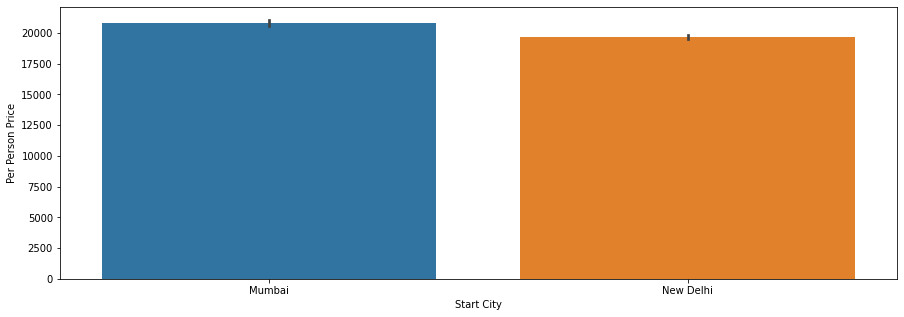

In [ ]:
sns.barplot(merged['Start City'],merged['Per Person Price'])

In [ ]:
# temp['Start City']=merged['Start City']
# temp['Price']=merged['Per Person Price']
# temp['Itinerary']=merged.Itinerary

In [ ]:
#temp.loc[(temp['New Delhi']==1) & (temp['Start City']=='New Delhi')][['Destination_list' ,	'Start City', 	'Price', 	'Itinerary']].head(20)

In [ ]:
merged=pd.get_dummies(merged,columns=['Start City'])

## Analyzing the Itinary Column
1. Adding the total number of stay day column

In [ ]:
#sorted(Destination_list)

In [ ]:
temp=pd.DataFrame(columns=Destination_list)
temp['Itinerary']=merged['Itinerary'].str.split(' . ')

In [ ]:
temp.fillna(0,inplace=True)

In [ ]:
temp['state']=''

In [ ]:
for index,row in temp.iterrows():
  states=''
  for values in row['Itinerary']:
    days=int(values.split('N ')[0])
    location=values.split('N ')[1]
    if location in indian_city_state.keys():
      state=indian_city_state[location]
      states=states +',' +state

  temp.at[index,'state']=str(states)

In [ ]:
temp.fillna(0,inplace=True)

In [ ]:
#temp.drop(['Itinerary'],axis=1,inplace=True)

In [ ]:
temp['state']=temp['state'].str.split(',')
#temp=temp.iloc[:,1:]

In [ ]:
temp.fillna(0,inplace=True)

In [ ]:
temp['state']=temp['state'].map(lambda x: list(set(x)) if len(x)>0 else -1)

In [ ]:
temp['state']

0        [, Himachal Pradesh, Chandigarh, Delhi]
1                          [, Jammu and Kashmir]
2                                  [, Rajasthan]
3                                     [, Kerala]
4                                             []
                          ...                   
29995                                 [, Kerala]
29996                      [, Jammu and Kashmir]
29997                       [, Himachal Pradesh]
29998                              [, Rajasthan]
29999                            [, Maharashtra]
Name: state, Length: 30000, dtype: object

In [ ]:
temp1=pd.DataFrame(columns=states)
temp1['state']=temp['state']

In [ ]:
for index,row in temp1.iterrows():
  for values in row['state']:
    if (values!=''):
      temp1.at[index,values]=1

In [ ]:
temp1.fillna(0,inplace=True)

In [ ]:
length=length.map(lambda x: len(set(x))-1 if x!=0 else x)

In [ ]:
length=length.map(lambda x: -1 if x==0 else x)

In [ ]:
# adding state to the cities

In [ ]:
for index, row in temp.iterrows():
  

In [ ]:
states

',Maharashtra'

In [ ]:
temp.shape

(30000, 182)

In [ ]:
merged.columns

Index(['Uniq Id', 'Package Name', 'Package Type', 'Destination', 'Itinerary',
       'Places Covered', 'Travel Date', 'Hotel Details', 'Start City',
       'Airline', 'Flight Stops', 'Meals', 'Sightseeing Places Covered',
       'Cancellation Rules', 'Per Person Price'],
      dtype='object')

In [ ]:
merged=pd.concat([merged,temp],axis=1)

In [ ]:
merged.shape

(60000, 197)

In [ ]:
temp=merged['Itinerary'].str.split(' . ',expand=True)
temp.columns=[1,2,3,4,5,6,7,8,9,10,11]
temp.fillna(0,inplace=True)
for i in temp.columns:
  temp[i]=temp[i].map(lambda x: x[:1] if (x!=0) else x)
  temp[i]=temp[i].astype(int)


In [ ]:
temp['places_length']=temp.gt(0).sum(axis=1)  
temp['Places']=merged['Places_covered']
temp['Total_stay_nights']=temp.sum(axis=1)
merged['Total_stay_nights']=temp['Total_stay_nights']
temp['length']=temp['Places'].map(lambda x: len(x) if x!=0 else x)

In [ ]:
temp.fillna(0,inplace=True)

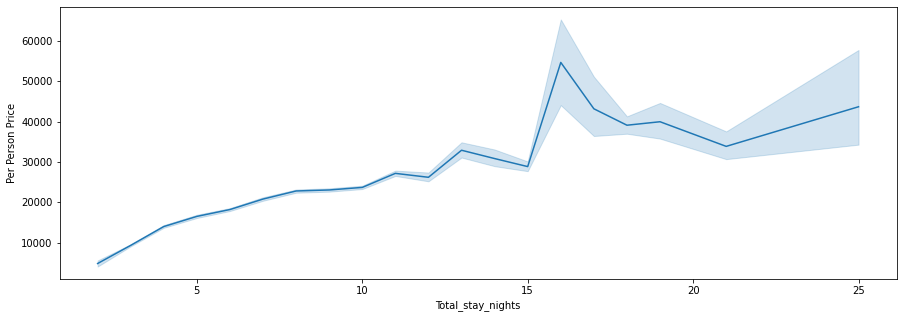

In [ ]:
sns.lineplot(merged['Total_stay_nights'],merged['Per Person Price'])

# Checking Hotel Details


In [ ]:
temp=merged[['Hotel Details','Airline','Flight Stops','Meals','Total_stay_nights','Places_covered']]

In [ ]:
temp1=merged['Hotel Details'].str.split('|',expand=True)
temp1.columns=[1,2,3,4,5,6,7,8,9,10,11]
#temp1['Itinerary']=merged['Itinerary']
temp1['Airline']=merged['Airline']
temp1['Flight Stops']=merged['Flight Stops']
temp1['Places_covered']=merged['Places_covered']
temp1['Meals']=merged['Meals']


## Playing with Travel Date

In [ ]:
df_train['Travel Date']=pd.to_datetime(df_train['Travel Date'],format='%d-%m-%Y')
df_train['Day']=df_train['Travel Date'].dt.day
df_train['Month']=df_train['Travel Date'].dt.month
df_train['Year']=df_train['Travel Date'].dt.year

In [ ]:
df_train['Travel Date'].nunique()

495

In [ ]:
df_train=df_train.sort_values(['Travel Date'])
temp=df_train

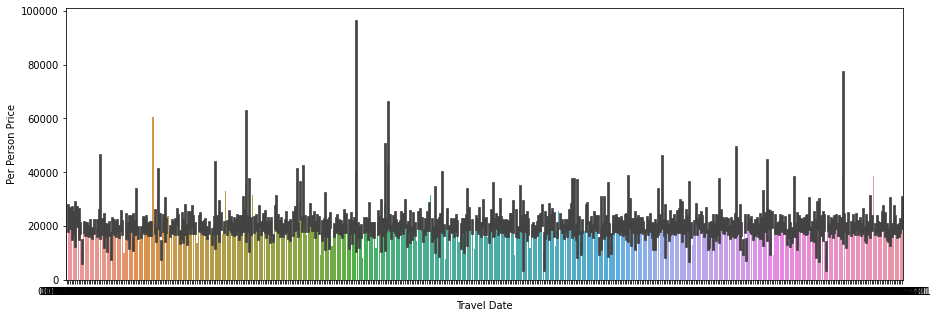

In [ ]:
sns.barplot(temp['Travel Date'],temp['Per Person Price'])

In [ ]:
merged['Travel Date']=pd.to_datetime(merged['Travel Date'],format='%d-%m-%Y')
merged['Day']=merged['Travel Date'].dt.day
merged['Month']=merged['Travel Date'].dt.month
merged['Year']=merged['Travel Date'].dt.year

,Uniq Id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,Per Person Price,Day,Month,Year
3393,349e0d65d7c0cd0ff250060d9df3d085,Scinitillating North East,Premium,Darjeeling|Pelling|Gangtok|Kalimpong,2N Darjeeling . 2N Pelling . 2N Gangtok . 1N K...,Darjeeling|Pelling|Gangtok|Kalimpong,2021-01-01,Ramada by Wyndham Darjeeling Gandhi Road:4.4|T...,Mumbai,IndiGo|IndiGo,0,5,Tiger Hill | Himalayan Mountaineering Institu...,Cancellation any time after making the 1st pay...,38311.0,1,1,2021
5210,cda1cc2d51e4c56da23f0818d32259a1,Ultimate Himachal from Delhi(with Flights),Deluxe,Parwanoo|Shimla|Chail|Kasauli,1N Parwanoo . 3N Shimla . 2N Chail . 1N Kasauli,Parwanoo|Shimla|Chail|Kasauli,2021-01-02,The Terrace:Four|Summit Thistle Villa Resort &...,Mumbai,IndiGo,1,3,Viceregal Lodge | Mall road | Sadhu Pul | Cri...,Cancellation any time after making the 1st pay...,22559.0,2,1,2021
8244,e23fc4e0292383c324dc6b563ccc2358,4 N in Kerala with Varkala,Standard,Allepey|Varkala|Kovalam,1N Allepey . 1N Varkala . 2N Kovalam,Allepey|Varkala|Kovalam,2021-01-03,"Camelot Hotel, Alleppey- MMT Holidays Special:...",New Delhi,IndiGo|IndiGo|IndiGo,2,3,Backwaters | Mullakkal Raja Rajeswari Temple ...,Cancellation any time after making the 1st pay...,9869.5,3,1,2021
10172,9e4bb410f77dbbe8ce8401cb518c7817,Himalayan Glitter - Lunch at Darjeeling Tea Es...,Luxury,Gangtok|Pelling|Darjeeling,3N Gangtok . 1N Pelling . 2N Darjeeling,Gangtok|Pelling|Darjeeling,2021-01-04,Mayfair Spa Resort & Casino:Five|The Chumbi Mo...,Mumbai,Spicejet,0,4,Baba Mandir | Changu Lake - Excursion | Rumte...,Cancellation any time after making the 1st pay...,60411.5,4,1,2021
7599,eebadee626a97a76643bd5e742668abf,Hills and Wildlife in Uttarakhand - Wildlife,Premium,Nainital|Corbett|Mussoorie,2N Nainital . 2N Corbett . 2N Mussoorie,Nainital|Corbett|Mussoorie,2021-01-05,Vikram Vintage Inn:4.1|Brys Caves:4.3|JW Marri...,New Delhi,Not Available,0,5,Nainital Zoo | Eco Cave Garden | Naina devi T...,Cancellation any time after making the 1st pay...,24822.0,5,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18362,f05f6769aaf04c0a696d17d27aec4f2f,3 Nights holiday to Cochin and Munnar,Standard,Cochin|Munnar,1N Cochin . 2N Munnar,Cochin|Munnar,2022-05-14,Quality Airport Hotel:4.0|Palmtree Leaf-MMT Ho...,New Delhi,IndiGo,2,3,Fort Cochin | Dutch Palace | Jewish Synagogue...,Cancellation any time after making the 1st pay...,7806.5,14,5,2022
829,0899bed9ce473c2c3acc6ab98d198b1f,Awesome Himachal Holiday fun from Chandigarh,Standard,Shimla|Manali|Chandigarh,2N Shimla . 4N Manali . 1N Chandigarh,Shimla|Manali|Chandigarh,2022-05-15,Not Available,New Delhi,Not Available,2,3,Kufri | Himalayan Zoo | Naldhera | Viceregal ...,Cancellation any time after making the 1st pay...,11447.0,15,5,2022
22270,fcea8f26e9b2dba762d8cef3a144532e,Sri Lanka - Kandy & Nuwara Eliya Special,Standard,Kandy|Nuwara Eliya|Colombo,2N Kandy . 1N Nuwara Eliya . 1N Colombo,Kandy|Nuwara Eliya|Colombo,2022-05-16,Oak Ray City Hotel-MMT HOLIDAYS SPECIAL:4|Heav...,Mumbai,IndiGo|IndiGo|IndiGo|IndiGo,2,3,Not Available,Cancellation any time after making the 1st pay...,NaN,16,5,2022
12022,6ea4ae672cb33fd1711168aa653ed8f5,"Beaches, backwaters and Hills of Kerala",Deluxe,Kovalam and Poovar|Allepey|Munnar,2N Kovalam and Poovar . 1N Allepey . 2N Munnar,Kovalam and Poovar|Allepey|Munnar,2022-05-17,Hotel Port Palace:|Warmth Lake Haven-MMT Holid...,New Delhi,IndiGo|IndiGo,1,3,Zoological Park | Napier Museum | Hawa Beach ...,Cancellation any time after making the 1st pay...,11891.0,17,5,2022


In [ ]:
import datetime
mergd['holiday']=merged['Travel Date'].map(lambda x: x.weekday())
merged.loc[merged['holiday']<=4,'holiday']=0
merged.loc[merged['holiday']>4,'holiday']=1

In [ ]:
public_holidays=['2021-01-01',
'2021-01-26',
'2021-04-02',
'2021-05-14',
'2021-08-15',
'2021-10-02',
'2021-10-15',
'2021-11-04',
'2021-12-25',
'2021-12-31',
'2022-01-01',
'2022-01-26',
'2022-04-15',
'2022-05-02',
'2022-08-15',
'2022-10-05',
'2022-10-02',
'2022-10-24',
'2022-12-25',
'2022-12-31'
]
merged.loc[merged['Travel Date'].isin(public_holidays),'holiday']=1

In [ ]:
drop_list=['Uniq Id','Package Name','Itinerary','Travel Date','Hotel Details','Airline','Sightseeing Places Covered','Cancellation Rules','Places_covered']

[link text](https://)# Dropping unncessary columns

In [ ]:
merged.drop(drop_list,axis=1,inplace=True)

In [ ]:
merged['Package Type']=merged['Package Type'].astype(int)

In [ ]:
df_train['Package Name'].head(50)

0          Best of Shimla and Manali Holiday from Delhi
1                               Kashmir Valley vacation
2               Might of Mewar- Udaipur and Chittorgarh
3                  Colorful Kerala ( Romantic Getaway )
4                           A Week In Bangkok & Pattaya
5           Cochin Trip with Visit to Guruvayoor Temple
6                                        Jaipur Holiday
7                     Kasol & Manali holiday from Delhi
8                      Charismatic Kashmir with Gulmarg
9     Luxury Getaway to Udaipur - Stay at the Chunda...
10                                    Essence of Kerala
11                         A Blissful holiday in Kerala
12                              A day visit to Guwahati
13    Holiday in Udaipur & Mount Abu by Volvo from A...
14            Himachal Marvels from Delhi(with Flights)
15               Drive to Nainital, Kausani and Corbett
16    Romantic Getaway - Spectacular Landscapes of K...
17                            Beautiful Kashmir 

## Training first iteration

In [ ]:
X_train=merged.iloc[:21000,:]
X_test_final=merged.iloc[21000:,:]
X=X_train.drop(['Per Person Price'],axis=1)
y=X_train['Per Person Price']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=4,
    n_estimator=100,
)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_test, Y_test)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[05:51:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:20997.6	validation_1-rmse:21749.8
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:19261	validation_1-rmse:20000.6
[2]	validation_0-rmse:17725.5	validation_1-rmse:18454
[3]	validation_0-rmse:16373.1	validation_1-rmse:17094.1
[4]	validation_0-rmse:15183.6	validation_1-rmse:15888.9
[5]	validation_0-rmse:14139.4	validation_1-rmse:14837.3
[6]	validation_0-rmse:13229.8	validation_1-rmse:13922.8
[7]	validation_0-rmse:12415.1	validation_1-rmse:13116.5
[8]	validation_0-rmse:11700.7	validation_1-rmse:12415
[9]	validation_0-rmse:11082.4	validation_1-rmse:11773.4
[10]	validation_0-rmse:10558.8	validation_1-rmse:11262
[11]	validation_0-rmse:10091.8	validation_1-rmse:10795.7
[12]	validation_0-rmse:9688.87	validation_1-rmse

9.00303602218628

In [ ]:
predictions=model.predict(X_test)
print("Mean Squared error is", np.sqrt(mean_squared_log_error(Y_test, predictions)))

Mean Squared error is 0.30643068876175183


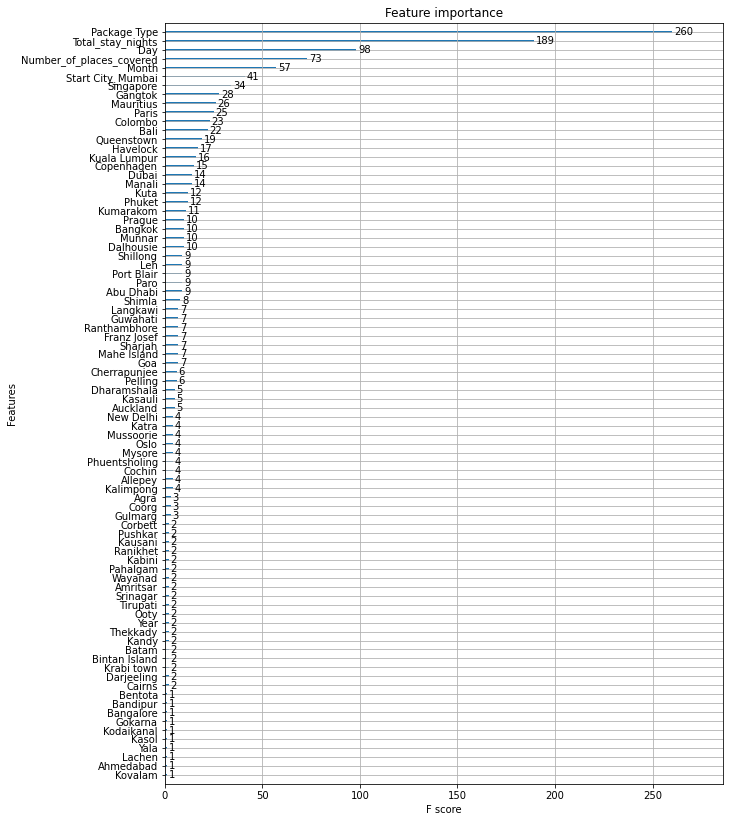

In [ ]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

## Submission

In [ ]:
submission['Per Person Price']=model.predict(X_test_final.drop(['Per Person Price'],axis=1))


In [ ]:
submission.to_csv('First.csv',index=False)